### https://www.kaggle.com/c/recognizing-faces-in-the-wild/leaderboard#score

In [ ]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-2it25gf5
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-2it25gf5
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=538ecb81019b212fb7087bb7d1c445f3b3f671c1e7c6ffa3855cb5a09bfd1831
  Stored in directory: /tmp/pip-ephem-wheel-cache-nzazqyah/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
from collections import defaultdict
from glob import glob
from random import choice, sample

from keras_vggface.utils import preprocess_input

import numpy as np
import pandas as pd

from keras.preprocessing import image
import tensorflow as tf
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
! pip install joblib
import joblib

import cv2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D
from keras.models import Model
from keras.preprocessing import image
from keras.optimizers import Adam
#from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
import h5py


from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


In [ ]:
pd

<module 'pandas' from '/usr/local/lib/python3.6/dist-packages/pandas/__init__.py'>

In [ ]:
! pip show cvxopt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Preparing files for dataset generation

In [ ]:
train_file_path = "drive/My Drive/Face_recognition/train_relationships.csv"
train_folders_path = "drive/My Drive/Face_recognition/train/"
val_famillies = "F09"

In [ ]:
all_images = glob(train_folders_path + "*/*/*.jpg")
all_images[:3]

['drive/My Drive/Face_recognition/train/F0009/MID4/P00089_face4.jpg',
 'drive/My Drive/Face_recognition/train/F0009/MID4/P11720_face2.jpg',
 'drive/My Drive/Face_recognition/train/F0009/MID4/P10574_face5.jpg']

In [ ]:
all_images = glob(train_folders_path + "*/*/*.jpg")
all_images = list(map(lambda x:x.replace("\\","/"),all_images))
all_images[0:3]

['drive/My Drive/Face_recognition/train/F0009/MID4/P00089_face4.jpg',
 'drive/My Drive/Face_recognition/train/F0009/MID4/P11720_face2.jpg',
 'drive/My Drive/Face_recognition/train/F0009/MID4/P10574_face5.jpg']

In [ ]:
#all_images[0:3]

In [ ]:
#Code inspiration link : https://www.kaggle.com/hsinwenchang/vggface-baseline-197x197

In [ ]:
train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]
print(len(train_images))
print(len(val_images))
print(all_images[0])
print(all_images[0].split("/")[-3] + "/" + all_images[0].split("/")[-2])

11252
1147
drive/My Drive/Face_recognition/train/F0009/MID4/P00089_face4.jpg
F0009/MID4


In [ ]:
train_images[-3:]

['drive/My Drive/Face_recognition/train/F1000/MID5/P10586_face1.jpg',
 'drive/My Drive/Face_recognition/train/F1000/MID3/P10578_face2.jpg',
 'drive/My Drive/Face_recognition/train/F1000/MID6/P10584_face1.jpg']

In [ ]:
train_person_to_images_map = defaultdict(list)
ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]
ppl[0:10]

['F0009/MID4',
 'F0009/MID4',
 'F0009/MID4',
 'F0009/MID4',
 'F0009/MID4',
 'F0009/MID4',
 'F0009/MID4',
 'F0009/MID4',
 'F0009/MID4',
 'F0009/MID4']

In [ ]:
for sample_img in train_images:
    train_person_to_images_map[sample_img.split("/")[-3] + "/" + sample_img.split("/")[-2]].append(sample_img)
    
val_person_to_images_map = defaultdict(list)
for sample_img in val_images:
    val_person_to_images_map[sample_img.split("/")[-3] + "/" + sample_img.split("/")[-2]].append(sample_img)

In [ ]:
train_person_to_images_map = dict(train_person_to_images_map)
val_person_to_images_map = dict(val_person_to_images_map)

In [ ]:
#'F0002\MID1' in val_images

In [ ]:
#val_person_to_images_map[list(val_person_to_images_map.keys())[0]]

In [ ]:
for k in val_person_to_images_map.keys():
    if len(val_person_to_images_map[k]) == 0:
        print("VAL Damn")
        print(k)
for k in train_person_to_images_map.keys():
    if len(train_person_to_images_map[k]) == 0:
        print("Train Damn")
        print(k)

In [ ]:
#train_file_path = "drive/My Drive/Face_recognition/train_relationships.csv"

In [ ]:
relationships = pd.read_csv(train_file_path)

In [ ]:
relationships = list(zip(relationships['p1'].values, relationships['p2'].values))

In [ ]:
len(relationships)

3598

In [ ]:
#ppl = [x.replace("\\","/") for x in ppl]

In [ ]:
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

In [ ]:
len(relationships)

3362

##### Getting train and val sets from relationships

In [ ]:
train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

In [ ]:
train[0:5]

[('F0002/MID1', 'F0002/MID3'),
 ('F0002/MID2', 'F0002/MID3'),
 ('F0005/MID1', 'F0005/MID2'),
 ('F0005/MID3', 'F0005/MID2'),
 ('F0009/MID1', 'F0009/MID4')]

In [ ]:
val[-5:]

[('F0998/MID5', 'F0998/MID3'),
 ('F0998/MID5', 'F0998/MID1'),
 ('F0998/MID6', 'F0998/MID1'),
 ('F0998/MID6', 'F0998/MID2'),
 ('F0998/MID6', 'F0998/MID3')]

In [ ]:
print(len(train))
print(len(val))

3066
296


In [ ]:
#from keras.preprocessing import image
def read_img(path):
    #change1
    img = image.load_img(path, target_size=(197, 197))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

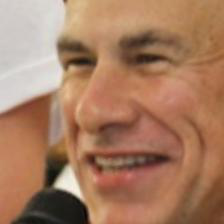

In [ ]:
image.load_img("drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg")

In [ ]:
len(np.array(image.load_img("drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg")))

224

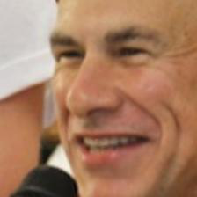

In [ ]:
image.load_img("drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg", target_size=(197, 197))

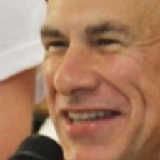

In [ ]:
image.load_img("drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg", target_size=(160, 160))

In [ ]:
len(np.array(image.load_img("drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg", target_size=(197, 197))))

197

In [ ]:
temp = read_img("drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg")

In [ ]:
temp.shape

(197, 197, 3)

In [ ]:
#temp

In [ ]:
#val_person_to_images_map

### 1. VGGFace and Distance metrics

In [ ]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        #sample() Chooses k unique random elements from a population sequence or set
        # Filling batch tuples with half 1 lables
        batch_tuples = sample(list_tuples, batch_size // 2)
        # Assigning 1 label to all the pairs given in relationships file
        labels = [1] * len(batch_tuples)
        # Filling half batch_tuples with 0 labels
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])
        
        # Selecting a single image out of many provided for each user
        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])
        
        # Selecting a single image out of many provided for each user
        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        yield [X1, X2], labels

In [ ]:
def baseline_model():
    #change 2
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x = Concatenate(axis=-1)([x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
file_path = "vgg_face.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = baseline_model()


In [ ]:
for k in val_person_to_images_map.keys():
    if len(val_person_to_images_map[k]) == 0:
        print("VAL Damn")
        print(k)
for k in train_person_to_images_map.keys():
    if len(train_person_to_images_map[k]) == 0:
        print("Train Damn")
        print(k)

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

In [ ]:
model

In [ ]:
! pip install joblib

In [ ]:

joblib.dump(model,"drive/My Drive/Face_recognition/model.pkl")

In [ ]:
! dir

In [ ]:
with open("vgg_face.h5",'rb') as f:
    with open("drive/My Drive/Face_recognition/vgg_face_copy.h5", "wb") as f1:
        for line in f:
            f1.write(line)

In [ ]:
model.load_weights('vgg_face.h5')

In [ ]:
model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

In [ ]:
model.save_weights("drive/My Drive/Face_recognition/vgg_face_copy(2).h5")

In [ ]:
model.load_weights("drive/My Drive/Face_recognition/vgg_face.h5")

In [ ]:
model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("vgg_face.csv", index=False)


0it [00:00, ?it/s]
1it [00:24, 24.43s/it]
2it [00:42, 22.55s/it]
3it [00:59, 20.89s/it]
4it [01:17, 20.07s/it]
5it [01:35, 19.31s/it]
6it [01:52, 18.73s/it]
7it [02:10, 18.38s/it]
8it [02:26, 17.70s/it]
9it [02:43, 17.43s/it]
10it [03:00, 17.37s/it]
11it [03:16, 17.03s/it]
12it [03:31, 16.50s/it]
13it [03:47, 16.38s/it]
14it [04:03, 16.06s/it]
15it [04:20, 16.33s/it]
16it [04:35, 15.96s/it]
17it [04:51, 16.07s/it]
18it [05:06, 15.60s/it]
19it [05:21, 15.38s/it]
20it [05:35, 15.22s/it]
21it [05:51, 15.24s/it]
22it [06:07, 15.55s/it]
23it [06:22, 15.46s/it]
24it [06:36, 15.02s/it]
25it [06:51, 15.08s/it]
26it [07:05, 14.58s/it]
27it [07:19, 14.33s/it]
28it [07:31, 13.71s/it]
29it [07:46, 14.04s/it]
30it [07:58, 13.50s/it]
31it [08:11, 13.27s/it]
32it [08:24, 13.30s/it]
33it [08:39, 13.71s/it]
34it [08:53, 13.81s/it]
35it [09:04, 13.16s/it]
36it [09:18, 13.19s/it]
37it [09:28, 12.25s/it]
38it [09:43, 13.09s/it]
39it [09:54, 12.55s/it]
40it [10:07, 12.76s/it]
41it [10:19, 12.59s/it]
42it 

#### Test AUC score on kaggle submission: 0.852

### 2. Experimenting with few additional layers at end and different dropouts

In [ ]:
def baseline_model2():
    #change 2
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x = Concatenate(axis=-1)([x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.0001))

    model.summary()

    return model

In [ ]:
file_path = "drive/My Drive/Face_recognition/vgg_face_baseline_model2.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_auroc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = baseline_model2()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
200/200 [==============================] - 116s 578ms/step - loss: 1.5499 - acc: 0.5709 - auroc: 0.6005 - val_loss: 0.6931 - val_acc: 0.6206 - val_auroc: 0.6713

Epoch 00001: val_auroc improved from -inf to 0.67125, saving model to drive/My Drive/Face_recognition/vgg_face_baseline_model2.h5
Epoch 2/100
200/200 [==============================] - 92s 459ms/step - loss: 0.6614 - acc: 0.6084 - auroc: 0.6545 - val_loss: 0.6613 - val_acc: 0.6400 - val_auroc: 0.6694

Epoch 00002: val_auroc did not improve from 0.67125
Epoch 3/100
200/200 [==============================] - 92s 458ms/step - loss: 0.6413 - acc: 0.6234 - auroc: 0.6792 - val_loss: 0.6560 - val_acc: 0.6375 - val_auroc: 0.6669

Epoch 00003: val_auroc did not improve from 0.67125
Epoch 4/100
200/200 [==============================] - 92s 458ms/step - loss: 0.6182 - acc: 0.6594 - auroc: 0.7100 - val_loss: 0.6179 - val_acc: 0.6756 - val_auroc: 0.7142

Epoch 00004: val_auroc improved from 0.67125 to 0.71422, saving model to 

In [ ]:
model.load_weights("drive/My Drive/Face_recognition/vgg_face_baseline_model2.h5")

In [ ]:
model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.0001))

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("vgg_face.csv", index=False)

166it [45:15, 12.36s/it]


### Test score: 0.825

### 3. Adding Cosine similiarity among other metrics

In [ ]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [ ]:
def cosine_model():
    #change 2
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
    
    x = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
file_path = "drive/My Drive/Face_recognition/vgg_face_cosine.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_auroc", mode="max", factor=0.1, patience=7, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = cosine_model()


W0730 03:44:42.807980 139937882212224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 03:44:42.825098 139937882212224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 03:44:42.830878 139937882212224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 03:44:42.852989 139937882212224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0730 03:44:42.854120 1399378822

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

Epoch 1/100

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



200/200 [==============================] - 109s 547ms/step - loss: 3.4510 - acc: 0.5600 - auroc: 0.5945 - val_loss: 3.8314 - val_acc: 0.5775 - val_auroc: 0.5927

Epoch 00001: val_auroc improved from -inf to 0.59273, saving model to drive/My Drive/Face_recognition/vgg_face_cosine.h5
Epoch 2/100
200/200 [==============================] - 90s 450ms/step - loss: 1.6573 - acc: 0.6275 - auroc: 0.6880 - val_loss: 2.1614 - val_acc: 0.5869 - val_auroc: 0.6169

Epoch 00002: val_auroc improved from 0.59273 to 0.61687, saving model to drive/My Drive/Face_recognition/vgg_face_cosine.h5
Epoch 3/100
200/200 [==============================] - 90s 450ms/step - loss: 1.0561 - acc: 0.6234 - auroc: 0.6745 - val_loss: 1.5515 - val_acc: 0.5781 - val_auroc: 0.6034

Epoch 00003: val_auroc did not improve from 0.61687
Epoch 4/100
200/200 [==============================] - 90s 450ms/step - loss: 0.7581 - acc: 0.6663 - auroc: 0.7195 - val_loss: 0.9396 - val_acc: 0.6338 - val_auroc: 0.6734

Epoch 00004: val_auro

In [ ]:
model.load_weights("drive/My Drive/Face_recognition/vgg_face_cosine.h5")

In [ ]:
model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("drive/My Drive/Face_recognition/cosine_submission.csv", index=False)

166it [32:28,  9.13s/it]


### Test Score: 0.858

### 4. Experimenting with dropouts and learning rates from previous model(Model 4)

In [ ]:
def cosine_model2():
    #change 2
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
    
    x = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
file_path = "drive/My Drive/Face_recognition/vgg_face_cosine2.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_auroc", mode="max", factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model2 = cosine_model2()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

In [ ]:
model2.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=100, validation_steps=100)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
100/100 [==============================] - 74s 744ms/step - loss: 4.1887 - acc: 0.5363 - auroc: 0.5628 - val_loss: 4.1303 - val_acc: 0.5719 - val_auroc: 0.5984

Epoch 00001: val_auroc improved from -inf to 0.59844, saving model to drive/My Drive/Face_recognition/vgg_face_cosine2.h5
Epoch 2/100
100/100 [==============================] - 53s 530ms/step - loss: 2.9020 - acc: 0.5981 - auroc: 0.6362 - val_loss: 2.9841 - val_acc: 0.6162 - val_auroc: 0.6570

Epoch 00002: val_auroc improved from 0.59844 to 0.65695, saving model to drive/My Drive/Face_recognition/vgg_face_cosine2.h5
Epoch 3/100
100/100 [==============================] - 53s 528ms/step - loss: 2.1237 - acc: 0.6038 - auroc: 0.6441 - val_loss: 2.3747 - val_acc: 0.5837 - val_auroc: 0.6227

Epoch 00003: val_auroc did not improve from 0.65695
Epoch 4/100
100/100 [==============================] - 53s 525ms/step - loss: 1.5186 - acc: 0.6106 - auroc: 0.6531 - val_loss: 1.8971 - val_acc: 0.5731 - val_auroc: 0.5910

Epoch 000

In [ ]:
model2.load_weights("drive/My Drive/Face_recognition/vgg_face_cosine2.h5")

In [ ]:
model2.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("drive/My Drive/Face_recognition/cosine_submission2.csv", index=False)

166it [01:18,  2.28it/s]


### test score : 0.858

### 5. Experimenting with focal loss and Global Max Pool layer

### https://www.kaggle.com/tenffe/vggface-cv-focal-loss

In [ ]:

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [ ]:
def cosine_focal_model():
    #change 2
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
    
    x = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
file_path = "drive/My Drive/Face_recognition/vgg_face_cosine_focal.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_auroc", mode="max", factor=0.1, patience=10, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = cosine_focal_model()


W0731 05:47:04.422280 139844433500032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0731 05:47:04.461184 139844433500032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0731 05:47:04.467456 139844433500032 deprecation.py:323] From <ipython-input-39-5d124dd4d6b8>:3: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0731 05:47:04.498289 139844433500032 deprecation.py:323] From <ipy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

Epoch 1/100

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



200/200 [==============================] - 296s 1s/step - loss: 22.2924 - acc: 0.5687 - auroc: 0.6291 - val_loss: 24.6558 - val_acc: 0.6000 - val_auroc: 0.6250

Epoch 00001: val_auroc improved from -inf to 0.62500, saving model to drive/My Drive/Face_recognition/vgg_face_cosine_focal.h5
Epoch 2/100
200/200 [==============================] - 136s 678ms/step - loss: 12.5627 - acc: 0.5809 - auroc: 0.6542 - val_loss: 17.2172 - val_acc: 0.5794 - val_auroc: 0.6200

Epoch 00002: val_auroc did not improve from 0.62500
Epoch 3/100
200/200 [==============================] - 97s 486ms/step - loss: 5.3335 - acc: 0.5997 - auroc: 0.6770 - val_loss: 6.9322 - val_acc: 0.5850 - val_auroc: 0.6465

Epoch 00003: val_auroc improved from 0.62500 to 0.64648, saving model to drive/My Drive/Face_recognition/vgg_face_cosine_focal.h5
Epoch 4/100
200/200 [==============================] - 89s 445ms/step - loss: 2.8715 - acc: 0.6134 - auroc: 0.6917 - val_loss: 3.6709 - val_acc: 0.6144 - val_auroc: 0.6909

Epoch 0

In [ ]:
model.load_weights("drive/My Drive/Face_recognition/vgg_face_cosine_focal.h5")

In [ ]:
model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=Adam(0.00001))

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("drive/My Drive/Face_recognition/cosine_focal_submission.csv", index=False)

166it [24:50,  6.76s/it]


### Test Score : 0.865

### 6. Passing the metrics through dense layers

### Monitoring Accuracy instead of ROCAUC

In [ ]:
def cosine_focal_model2():
    #change 2
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = GlobalMaxPool2D()(x1)
    x2 = GlobalMaxPool2D()(x2)

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])
    x3 = Dense(100, activation = 'relu')(x3)

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x4 = Dense(100, activation = 'relu')(x4)
    
    
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
    x5 = Dense(100, activation = 'relu')(x5)
    
    x = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.05)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
file_path = "drive/My Drive/Face_recognition/vgg_face_cosine_focal2"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=10, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = cosine_focal_model2()

94699520/94694792 [==============================] - 4s 0us/step


W0801 01:26:19.410187 140346887079808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0801 01:26:19.460252 140346887079808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0801 01:26:19.469247 140346887079808 deprecation.py:323] From <ipython-input-44-5d124dd4d6b8>:3: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0801 01:26:19.509076 140346887079808 deprecation.py:323] From <ipy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

Epoch 1/100

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



200/200 [==============================] - 621s 3s/step - loss: 13.1002 - acc: 0.5353 - auroc: 0.5678 - val_loss: 11.5723 - val_acc: 0.5238 - val_auroc: 0.5599

Epoch 00001: val_acc improved from -inf to 0.52375, saving model to drive/My Drive/Face_recognition/vgg_face_cosine_focal2
Epoch 2/100
200/200 [==============================] - 305s 2s/step - loss: 5.4389 - acc: 0.5816 - auroc: 0.6530 - val_loss: 6.3874 - val_acc: 0.5506 - val_auroc: 0.6009

Epoch 00002: val_acc improved from 0.52375 to 0.55063, saving model to drive/My Drive/Face_recognition/vgg_face_cosine_focal2
Epoch 3/100
200/200 [==============================] - 202s 1s/step - loss: 3.2549 - acc: 0.5778 - auroc: 0.6445 - val_loss: 4.3567 - val_acc: 0.5487 - val_auroc: 0.5866

Epoch 00003: val_acc did not improve from 0.55063
Epoch 4/100
200/200 [==============================] - 191s 953ms/step - loss: 2.0147 - acc: 0.5891 - auroc: 0.6484 - val_loss: 2.5833 - val_acc: 0.5563 - val_auroc: 0.6044

Epoch 00004: val_acc im

In [ ]:
# def triplet_loss(y_true, y_pred, alpha = 0.3):    
#     anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]    
#     pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)    
#     neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)    
#     basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)    
#     loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))       
#     return loss

In [ ]:
model.load_weights("drive/My Drive/Face_recognition/vgg_face_cosine_focal2")

In [ ]:
model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=Adam(0.00001))

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("drive/My Drive/Face_recognition/cosine_focal_submission2.csv", index=False)

166it [54:19, 14.17s/it]


### Test Score 0.8666

### 7. Siamese model using custom layers instead of VGGFace with 197X197X3 input

### https://github.com/hlamba28/One-Shot-Learning-with-Siamese-Networks/blob/master/Siamese%20on%20Omniglot%20Dataset.ipynb

In [ ]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [ ]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [ ]:



def get_siamese_model(input_shape=(197, 197, 3)):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [ ]:
file_path = "siamese_model1.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_auroc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = get_siamese_model()

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         304250176   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16),
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=20, verbose=2,
                    callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

In [ ]:
### The above model takes a lot of time and runs out of memroy  so, reducing the trainable params

In [ ]:
### Siamese model with 160X160X3 input

In [ ]:
#from keras.preprocessing import image
def read_img2(path):
    #change1
    img = image.load_img(path, target_size=(160, 160))
    img = np.array(img).astype(np.float)
    return img
def gen2(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        #sample() Chooses k unique random elements from a population sequence or set
        # Filling batch tuples with half 1 lables
        batch_tuples = sample(list_tuples, batch_size // 2)
        # Assigning 1 label to all the pairs given in relationships file
        labels = [1] * len(batch_tuples)
        # Filling half batch_tuples with 0 labels
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])
        
        # Selecting a single image out of many provided for each user
        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img2(x) for x in X1])
        
        # Selecting a single image out of many provided for each user
        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img2(x) for x in X2])

        yield [X1, X2], labels


In [ ]:
def get_siamese_model2(input_shape=(160, 160,3)):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

file_path = "siamese_model2.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_auroc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = get_siamese_model2()

In [ ]:
model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.0001))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4096)         152206656   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4096)         0           sequential_3[1][0]               
          

In [ ]:
model.fit_generator(gen2(train, train_person_to_images_map, batch_size=16),
                    validation_data=gen2(val, val_person_to_images_map, batch_size=16), epochs=20, verbose=1,
                    callbacks=callbacks_list, steps_per_epoch=100, validation_steps=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 865s 9s/step - loss: 10.7282 - acc: 0.5187 - auroc: 0.5380 - val_loss: 6.7384 - val_acc: 0.5000 - val_auroc: 0.4980

Epoch 00001: val_auroc improved from -inf to 0.49797, saving model to siamese_model1.h5
Epoch 2/20
100/100 [==============================] - 854s 9s/step - loss: 4.7585 - acc: 0.5000 - auroc: 0.5149 - val_loss: 3.3080 - val_acc: 0.5000 - val_auroc: 0.4872

Epoch 00002: val_auroc did not improve from 0.49797
Epoch 3/20
100/100 [==============================] - 774s 8s/step - loss: 2.5574 - acc: 0.5000 - auroc: 0.5130 - val_loss: 1.9874 - val_acc: 0.5000 - val_auroc: 0.5055

Epoch 00003: val_auroc improved from 0.49797 to 0.50555, saving model to siamese_model1.h5
Epoch 4/20
100/100 [==============================] - 777s 8s/step - loss: 1.6681 - acc: 0.5000 - auroc: 0.5066 - val_loss: 1.4157 - val_acc: 0.5000 - val_auroc: 0.5403

Epoch 00004: val_auroc improved from 0.5

In [ ]:
model.load_weights('siamese_model1.h5')

In [ ]:
model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.0001))

#### Ignoring the above model due to low scores

### 8. Using pre-trained models for feature extraction and using those features in classical ml models

In [ ]:
base_model = VGGFace(model='resnet50', include_top=False)

W0801 16:12:53.832464 139786712209280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 16:12:53.885083 139786712209280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 16:12:53.894682 139786712209280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 16:12:53.943369 139786712209280 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0801 16:12:53.944971 1397867122

94699520/94694792 [==============================] - 1s 0us/step


In [ ]:
np.array(read_img('drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg')).shape

(197, 197, 3)

In [ ]:
np.expand_dims(np.array(read_img('drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg')), axis=0).shape

(1, 197, 197, 3)

In [ ]:
base_model.predict(np.expand_dims(np.array(read_img('drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg')), axis=0)).shape

(1, 1, 1, 2048)

In [ ]:
base_model.predict(np.expand_dims(np.array(read_img('drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg')), axis=0)).reshape((2048)).shape

(2048,)

In [ ]:
### Generating training and validation sets

In [ ]:
training_set = []
training_labels = []
ppl = list(train_person_to_images_map.keys())
for p1,p2 in train:
    #print(p1)
    img1 = choice(train_person_to_images_map[p1])
    img2 = choice(train_person_to_images_map[p2])
    
    #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
    training_set.append(np.concatenate((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)), base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))))
    training_labels.append(1)
    
    flag = 0
    while(flag == 0):
        p1 = choice(ppl)
        p2 = choice(ppl)
        
        if p1 != p2 and (p1, p2) not in train and (p2, p1) not in train:
            flag=1
            img1 = choice(train_person_to_images_map[p1])
            img2 = choice(train_person_to_images_map[p2])
            #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
            training_set.append(np.concatenate((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)), base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))))
            training_labels.append(0)
    

In [ ]:
training_set = np.array(training_set)

In [ ]:
training_set.shape

(6132, 4096)

In [ ]:
len(train)*2

6132

In [ ]:
len(training_labels)

6132

In [ ]:
! pip install joblib
import joblib

In [ ]:
joblib.dump(training_set,"drive/My Drive/Face_recognition/X_train1")

['drive/My Drive/Face_recognition/X_train1']

In [ ]:
joblib.dump(training_labels,"drive/My Drive/Face_recognition/y_train1")

['drive/My Drive/Face_recognition/y_train1']

In [ ]:
training_set.shape

(6132, 4096)

In [ ]:
val_set = []
val_labels = []
ppl = list(val_person_to_images_map.keys())
for p1,p2 in val:
    #print(p1)
    img1 = choice(val_person_to_images_map[p1])
    img2 = choice(val_person_to_images_map[p2])
    
    #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
    val_set.append(np.concatenate((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)), base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))))
    val_labels.append(1)
    
    flag = 0
    while(flag == 0):
        p1 = choice(ppl)
        p2 = choice(ppl)
        
        if p1 != p2 and (p1, p2) not in val and (p2, p1) not in val:
            flag=1
            img1 = choice(val_person_to_images_map[p1])
            img2 = choice(val_person_to_images_map[p2])
            #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
            val_set.append(np.concatenate((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)), base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))))
            val_labels.append(0)

In [ ]:
joblib.dump(val_set,"drive/My Drive/Face_recognition/X_val1")
joblib.dump(val_labels,"drive/My Drive/Face_recognition/y_val1")

['drive/My Drive/Face_recognition/y_val1']

In [ ]:
len(val_labels)

592

In [ ]:
val_set = np.array(val_set)

In [ ]:
val_set.shape

(592, 4096)

In [ ]:
len(val)*2

592

#### Getting base scores on a simple RF model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(training_set, training_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
val_pred = rf.predict(val_set)

In [ ]:
val_prob = rf.predict_proba(val_set)

In [ ]:
from sklearn import metrics

In [ ]:
metrics.roc_auc_score(val_labels, val_prob[:,1])

0.6606213476990505

In [ ]:
import joblib
X_train = joblib.load("drive/My Drive/Face_recognition/X_train1")
y_train = joblib.load("drive/My Drive/Face_recognition/y_train1")

In [ ]:
X_val = joblib.load("drive/My Drive/Face_recognition/X_val1")
y_val = joblib.load("drive/My Drive/Face_recognition/y_val1")

#### Trying out tuning of XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [ ]:
params = {'max_depth':[2,4,6,8], 'n_estimators':[10,50,100,200]}
model = GridSearchCV(XGBClassifier(n_jobs=-1), param_grid=params,scoring='roc_auc',n_jobs=-1,cv=3, return_train_score=True, verbose=1)
model.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 88.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'n_estimators': [10, 50, 100, 200]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
model.best_score_

0.6681436320071281

In [ ]:
joblib.dump(model,"drive/My Drive/Face_recognition/xgb1")

['drive/My Drive/Face_recognition/xgb1']

In [ ]:
val_proba = model.best_estimator_.predict(X_val)

In [ ]:
roc_auc_score(y_val,val_proba)

0.6959459459459459

#### Experimenting by tripling the size of train and val sets

In [ ]:
training_set = []
training_labels = []
ppl = list(train_person_to_images_map.keys())
count = 0
while(count !=3):
    for p1,p2 in train:
        #print(p1)
        img1 = choice(train_person_to_images_map[p1])
        img2 = choice(train_person_to_images_map[p2])

        #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
        training_set.append(np.concatenate((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)), base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))))
        training_labels.append(1)

        flag = 0
        while(flag == 0):
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in train and (p2, p1) not in train:
                flag=1
                img1 = choice(train_person_to_images_map[p1])
                img2 = choice(train_person_to_images_map[p2])
                #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
                training_set.append(np.concatenate((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)), base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))))
                training_labels.append(0)
    count+=1

In [ ]:
training_set = np.array(training_set)

In [ ]:
joblib.dump(training_set,"drive/My Drive/Face_recognition/X_train2")

['drive/My Drive/Face_recognition/X_train2']

In [ ]:
joblib.dump(training_labels,"drive/My Drive/Face_recognition/y_train2")

['drive/My Drive/Face_recognition/y_train2']

In [ ]:
val_set = []
val_labels = []
ppl = list(val_person_to_images_map.keys())
count=0
while(count !=3):
    for p1,p2 in val:
        #print(p1)
        img1 = choice(val_person_to_images_map[p1])
        img2 = choice(val_person_to_images_map[p2])

        #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
        val_set.append(np.concatenate((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)), base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))))
        val_labels.append(1)

        flag = 0
        while(flag == 0):
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in val and (p2, p1) not in val:
                flag=1
                img1 = choice(val_person_to_images_map[p1])
                img2 = choice(val_person_to_images_map[p2])
                #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
                val_set.append(np.concatenate((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)), base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))))
                val_labels.append(0)
    count+=1

In [ ]:
val_set = np.array(val_set)

In [ ]:
joblib.dump(val_set, "drive/My Drive/Face_recognition/val_train2")
joblib.dump(val_labels, "drive/My Drive/Face_recognition/y_val2")

['drive/My Drive/Face_recognition/y_val2']

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=50)

In [ ]:
model.fit(training_set,training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
train_proba = model.predict(training_set)

In [ ]:
metrics.roc_auc_score(training_labels, train_proba)

1.0

In [ ]:
val_proba = model.predict(val_set)
metrics.roc_auc_score(val_labels, val_proba)

0.6373873873873873

### Adding distance metrics and cosine sim along with featurized images

In [ ]:
X_train.shape

(6132, 4096)

In [ ]:
X_val.shape

(592, 4096)

In [ ]:
euc_train = X_train[:,:2048]**2 - X_train[:,2048:]**2

In [ ]:
euc_val = X_val[:,:2048]**2 - X_val[:,2048:]**2

In [ ]:
euc_train = np.sum(euc_train, axis=1)

In [ ]:
euc_val = np.sum(euc_val, axis=1)

In [ ]:
dis_train = (X_train[:,:2048] - X_train[:,2048:])**2

In [ ]:
dis_train = np.sum(dis_train, axis=1)

In [ ]:
dis_val = (X_val[:,:2048] - X_val[:,2048:])**2
dis_val = np.sum(dis_val, axis=1)

In [ ]:
from scipy import spatial

In [ ]:
cosine_train = np.array(list(map(lambda x,y: 1-spatial.distance.cosine(x,y), X_train[:,:2048], X_train[:,2048:])))

In [ ]:
cosine_val = np.array(list(map(lambda x,y: 1-spatial.distance.cosine(x,y), X_val[:,:2048], X_val[:,2048:])))

In [ ]:
print(X_train.shape)
print(euc_train.shape)
print(dis_train.shape)
print(cosine_train.shape)

(6132, 4096)
(6132,)
(6132,)
(6132,)


In [ ]:
X_train = np.column_stack((X_train, euc_train, dis_train, cosine_train))

In [ ]:
X_val = np.column_stack((X_val, euc_val, dis_val, cosine_val))

In [ ]:
X_train.shape

(6132, 4099)

In [ ]:
X_val.shape

(592, 4099)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
rf = XGBClassifier(max_depth=5,n_estimators=200)
rf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
train_pred_proba = rf.predict_proba(X_train)

In [ ]:
from sklearn import metrics

In [ ]:

metrics.roc_auc_score(y_train, train_pred_proba[:,1])

1.0

In [ ]:
val_pred_proba = rf.predict_proba(X_val)
metrics.roc_auc_score(y_val, val_pred_proba[:,1])

0.8506665449233017

In [ ]:
### Hyper param tuning the XGBoost

In [ ]:
params = {'max_depth':[2,4,6,8], 'n_estimators':[10,50,100,200]}
model = GridSearchCV(XGBClassifier(n_jobs=-1), param_grid=params,scoring='roc_auc',n_jobs=-1,cv=3, return_train_score=True, verbose=1)
model.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 88.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'n_estimators': [10, 50, 100, 200]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
from sklearn import metrics

In [ ]:
train_pred_proba = model.best_estimator_.predict_proba(X_train)
metrics.roc_auc_score(y_train, train_pred_proba[:,1])

0.8591487918117144

In [ ]:
val_pred_proba = model.best_estimator_.predict_proba(X_val)
metrics.roc_auc_score(y_val, val_pred_proba[:,1])

0.8528465120525931

In [ ]:
# test_path = "drive/My Drive/Face_recognition/test/"
# def chunker(seq, size=32):
#     return (seq[pos:pos + size] for pos in range(0, len(seq), size))


# from tqdm import tqdm

# submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

# predictions = []

# for batch in tqdm(chunker(submission.img_pair.values)):
#     X1 = [x.split("-")[0] for x in batch]
#     X1 = np.array([read_img(test_path + x) for x in X1])

#     X2 = [x.split("-")[1] for x in batch]
#     X2 = np.array([read_img(test_path + x) for x in X2])

#     pred = model.predict([X1, X2]).ravel().tolist()
#     predictions += pred

# submission['is_related'] = predictions

# submission.to_csv("vgg_face.csv", index=False)

In [ ]:
submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
X_test = []
for img_pair in submission['img_pair'].values:
    x1 = img_pair.split('-')[0]
    x1 = np.array(read_img(test_path + x1))
    x1 = base_model.predict(np.expand_dims(x1,axis=0)).reshape(2048)
    x2 = img_pair.split('-')[1]
    x2 = np.array(read_img(test_path + x2))
    x2 = base_model.predict(np.expand_dims(x2,axis=0)).reshape(2048)
    euc = np.sum(x1**2 - x2**2)
    dis = np.sum((x1-x2)**2)
    cosine = 1-spatial.distance.cosine(x1,x2)
    ip = np.concatenate((x1,x2, [euc,dis,cosine]))
    X_test.append(ip)

In [ ]:
test_proba = model.best_estimator_.predict_proba(X_test)

In [ ]:
submission['is_related'] = test_proba[:,1]

In [ ]:
submission.to_csv("drive/My Drive/Face_recognition/xgbpred.csv",index=False)

### Test score: 84.0

### 9. Taking mean of different models and other miscellaneous experimentation

In [ ]:
sub_files = ['/content/drive/My Drive/Face_recognition/cosine_focal_submission.csv',
        '/content/drive/My Drive/Face_recognition/cosine_focal_submission2.csv',
        '/content/drive/My Drive/Face_recognition/cosine_submission.csv',
        '/content/drive/My Drive/Face_recognition/cosine_submission2.csv',
        '/content/drive/My Drive/Face_recognition/xgbpred.csv'
        ]

In [ ]:
for f in sub_files:
    d = pd.read_csv(f)
    print(d.head())

                      img_pair  is_related
0  face05508.jpg-face01210.jpg    0.042997
1  face05750.jpg-face00898.jpg    0.658368
2  face05820.jpg-face03938.jpg    0.579603
3  face02104.jpg-face01172.jpg    0.633630
4  face02428.jpg-face05611.jpg    0.624601
                      img_pair  is_related
0  face05508.jpg-face01210.jpg    0.090727
1  face05750.jpg-face00898.jpg    0.665668
2  face05820.jpg-face03938.jpg    0.507103
3  face02104.jpg-face01172.jpg    0.572642
4  face02428.jpg-face05611.jpg    0.531363
                      img_pair  is_related
0  face05508.jpg-face01210.jpg    0.000461
1  face05750.jpg-face00898.jpg    0.946379
2  face05820.jpg-face03938.jpg    0.584920
3  face02104.jpg-face01172.jpg    0.623860
4  face02428.jpg-face05611.jpg    0.844366
                      img_pair  is_related
0  face05508.jpg-face01210.jpg    0.000461
1  face05750.jpg-face00898.jpg    0.946379
2  face05820.jpg-face03938.jpg    0.584920
3  face02104.jpg-face01172.jpg    0.623860
4  face0242

In [ ]:
scores = []
for f in sub_files:
    d = pd.read_csv(f)
    scores.append(np.array(d['is_related']))

In [ ]:
scores = np.array(scores)

In [ ]:
scores.shape

(5, 5310)

In [ ]:
submission = pd.read_csv('/content/drive/My Drive/Face_recognition/sample_submission.csv')

In [ ]:
submission['is_related'] = np.sum(scores, axis=0)

In [ ]:
submission.head()


,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.332984
1,face05750.jpg-face00898.jpg,3.810393
2,face05820.jpg-face03938.jpg,2.993161
3,face02104.jpg-face01172.jpg,3.301096
4,face02428.jpg-face05611.jpg,3.417211


In [ ]:
submission.to_csv("/content/drive/My Drive/Face_recognition/sub5.csv", index=False)

In [ ]:
sub_files

['/content/drive/My Drive/Face_recognition/cosine_focal_submission.csv',
 '/content/drive/My Drive/Face_recognition/cosine_focal_submission2.csv',
 '/content/drive/My Drive/Face_recognition/cosine_submission.csv',
 '/content/drive/My Drive/Face_recognition/cosine_submission2.csv',
 '/content/drive/My Drive/Face_recognition/xgbpred.csv']

In [ ]:
scores[0]

array([0.04299739, 0.65836751, 0.57960308, ..., 0.5060814 , 0.41394684,
       0.43831879])

In [ ]:
scores[0] = scores[0]*0.3
scores[1] = scores[1]*0.3
scores[2] = scores[2]*0.15
scores[3] = scores[3]*0.15
scores[4] = scores[4]*0.1

In [ ]:
submission['is_related'] = np.sum(scores, axis=0)

In [ ]:
submission.to_csv("/content/drive/My Drive/Face_recognition/sub6.csv", index=False)

In [ ]:
#from keras.preprocessing import image
def read_img_facenet(path):
    #change1
    img = image.load_img(path, target_size=(160, 160))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

In [ ]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        #sample() Chooses k unique random elements from a population sequence or set
        # Filling batch tuples with half 1 lables
        batch_tuples = sample(list_tuples, batch_size // 2)
        # Assigning 1 label to all the pairs given in relationships file
        labels = [1] * len(batch_tuples)
        # Filling half batch_tuples with 0 labels
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])
        
        # Selecting a single image out of many provided for each user
        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img_facenet(x) for x in X1])
        
        # Selecting a single image out of many provided for each user
        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img_facenet(x) for x in X2])

        yield [X1, X2], labels
        
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)


In [ ]:

# example of loading the keras facenet model
from keras.models import load_model


In [ ]:
base_model = load_model('/content/drive/My Drive/Face_recognition/facenet_keras.h5')
t = base_model.predict(np.expand_dims(np.array(read_img_facenet('drive/My Drive/Face_recognition/train/F0002/MID1/P00010_face4.jpg')), axis=0))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
t.shape

(1, 128)

In [ ]:
def face_cosine_focal_model():
    #change 2
    input_1 = Input(shape=(160, 160, 3))
    input_2 = Input(shape=(160, 160, 3))

    base_model = load_model('/content/drive/My Drive/Face_recognition/facenet_keras.h5')

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    #x1 = GlobalAvgPool2D()(x1)
    #x2 = GlobalAvgPool2D()(x2)

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
    
    x = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=Adam(0.00001))

    model.summary()

    return model


In [ ]:
file_path = "drive/My Drive/Face_recognition/facenet_cosine_focal.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_auroc", mode="max", factor=0.1, patience=10, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = face_cosine_focal_model()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
W0806 02:58:22.415379 140359944357760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 02:58:22.427185 140359944357760 deprecation.py:323] From <ipython-input-57-512924c48ae6>:34: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0806 02:58:22.469060 140359944357760 deprecation.py:323] From <ipython-input-2-bc412d992b42>:14: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Inst

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Model)     (None, 128)          22808144    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
multiply_5 (Multiply)           (None, 128)          0           inception_resnet_v1[1][0]        
          

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


200/200 [==============================] - 522s 3s/step - loss: 14.4668 - acc: 0.4959 - auroc: 0.4809 - val_loss: 8.5882 - val_acc: 0.5231 - val_auroc: 0.5422

Epoch 00001: val_auroc improved from -inf to 0.54219, saving model to drive/My Drive/Face_recognition/facenet_cosine_focal.h5
Epoch 2/100
200/200 [==============================] - 233s 1s/step - loss: 7.1287 - acc: 0.5278 - auroc: 0.5331 - val_loss: 6.0816 - val_acc: 0.5294 - val_auroc: 0.5506

Epoch 00002: val_auroc improved from 0.54219 to 0.55063, saving model to drive/My Drive/Face_recognition/facenet_cosine_focal.h5
Epoch 3/100
200/200 [==============================] - 152s 758ms/step - loss: 5.3286 - acc: 0.5406 - auroc: 0.5727 - val_loss: 5.6818 - val_acc: 0.5169 - val_auroc: 0.5436

Epoch 00003: val_auroc did not improve from 0.55063
Epoch 4/100
200/200 [==============================] - 141s 705ms/step - loss: 4.7327 - acc: 0.5269 - auroc: 0.5711 - val_loss: 4.4726 - val_acc: 0.5531 - val_auroc: 0.6067

Epoch 00004: v

In [ ]:
def sum_output_shape(shapes):
    #print("***********************",shapes)
    shape1, shape2 = shapes
    return (shape1,1)

def sum_fn(x):
    return K.sum(x, axis=1, keepdims=True)


In [ ]:
from keras.optimizers import SGD

In [ ]:
# def cosine_focal_model2():
#     #change 2
#     input_1 = Input(shape=(197, 197, 3))
#     input_2 = Input(shape=(197, 197, 3))

#     base_model = VGGFace(model='resnet50', include_top=False)

#     for x in base_model.layers[:-3]:
#         x.trainable = True

#     x1 = base_model(input_1)
#     x2 = base_model(input_2)

#     x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
#     x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

#     x3 = Subtract()([x1, x2])
#     x3 = Multiply()([x3, x3])
#     x3 = Lambda(sum_fn, output_shape=sum_output_shape)(x3)

#     x1_ = Multiply()([x1, x1])
#     x2_ = Multiply()([x2, x2])
#     x4 = Subtract()([x1_, x2_])
#     x4 = Lambda(sum_fn, output_shape=sum_output_shape)(x4)
    
#     #https://stackoverflow.com/a/51003359/10650182
#     x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
    
#     x = Concatenate(axis=-1)([x5,x4, x3, x1, x2])

#     x = Dense(100, activation="relu")(x)
#     x = Dropout(0.01)(x)
#     out = Dense(1, activation="sigmoid")(x)

#     model = Model([input_1, input_2], out)

#     model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))

#     model.summary()

#     return model

In [ ]:
def cosine_focal_model2():
    #change 2
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    
    
    
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
    
    x6 = Lambda(sum_fn, output_shape=sum_output_shape)(x3)
    
    x7 = Lambda(sum_fn, output_shape=sum_output_shape)(x4)
    
    
    x = Concatenate(axis=-1)([x7, x6, x5,x4, x3])

    x = Dense(200, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=Adam(0.00001))

    model.summary()

    return model

In [ ]:
#model = cosine_focal_model()

In [ ]:

file_path = "drive/My Drive/Face_recognition/vgg_face_cosine_focal_withvectors.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_auroc", mode="max", factor=0.1, patience=10, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = cosine_focal_model2()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

#### Interrupting the cell below because of score stuck at 0.5

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
 92/200 [============>.................] - ETA: 2:03 - loss: 32.2362 - acc: 0.5000 - auroc: 0.5000

Process ForkPoolWorker-48:
Process ForkPoolWorker-45:
Process ForkPoolWorker-41:
Process ForkPoolWorker-43:
Process ForkPoolWorker-46:
Traceback (most recent call last):
Process ForkPoolWorker-44:
Process ForkPoolWorker-42:
Process ForkPoolWorker-47:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessin

Epoch 1/100

  File "<ipython-input-30-4a8ec4dc9549>", line 4, in read_img
    img = np.array(img).astype(np.float)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
base_model = VGGFace(model='resnet50', include_top=False)

W0807 02:10:21.755585 140385125271424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 02:10:21.804287 140385125271424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 02:10:21.813905 140385125271424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 02:10:21.857730 140385125271424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 02:10:21.859973 1403851252

94699520/94694792 [==============================] - 8s 0us/step


In [ ]:
training_set = []
training_labels = []
ppl = list(train_person_to_images_map.keys())
count = 0
while(count !=3):
    for p1,p2 in train:
        #print(p1)
        img1 = choice(train_person_to_images_map[p1])
        img2 = choice(train_person_to_images_map[p2])

        #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
        training_set.append((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)) - base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))**2)
        training_labels.append(1)

        flag = 0
        while(flag == 0):
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in train and (p2, p1) not in train:
                flag=1
                img1 = choice(train_person_to_images_map[p1])
                img2 = choice(train_person_to_images_map[p2])
                #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
                training_set.append((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)) - base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))**2)
                training_labels.append(0)
    count+=1
training_set = np.array(training_set)

In [ ]:
from scipy import spatial

In [ ]:
training_sim_metrics = []
training_set = []
training_labels = []
ppl = list(train_person_to_images_map.keys())
count = 0
while(count !=3):
    for p1,p2 in train:
        #print(p1)
        img1 = choice(train_person_to_images_map[p1])
        img2 = choice(train_person_to_images_map[p2])

        #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
        pred1 = base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048))
        pred2 = base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048))
        
        training_sim_metrics.append([np.sum((pred1-pred2)**2), np.sum((pred1**2 - pred2**2)), 1 - spatial.distance.cosine(pred1, pred2)] )
        training_set.append((pred1-pred2)**2)
        training_labels.append(1)

        flag = 0
        while(flag == 0):
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in train and (p2, p1) not in train:
                flag=1
                img1 = choice(train_person_to_images_map[p1])
                img2 = choice(train_person_to_images_map[p2])
                #print(base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)).shape)
                #training_set.append((base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048)) - base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048)))**2)
                
                pred1 = base_model.predict(np.expand_dims(np.array(read_img(img1)), axis=0)).reshape((2048))
                pred2 = base_model.predict(np.expand_dims(np.array(read_img(img2)), axis=0)).reshape((2048))
        
                training_sim_metrics.append([np.sum((pred1-pred2)**2), np.sum((pred1**2 - pred2**2)), 1 - spatial.distance.cosine(pred1, pred2)] )
                training_set.append((pred1-pred2)**2)
                training_labels.append(0)
    count+=1

In [ ]:
training_set = np.array(training_set)
training_sim_metrics = np.array(training_sim_metrics)
training_labels = np.array(training_labels)

In [ ]:
training_sim_metrics[1]

array([ 1.86470840e+04, -6.60191211e+03,  2.22686201e-01])

In [ ]:
print(training_set.shape)
print(training_sim_metrics.shape)
print(training_labels.shape)

(18396, 2048)
(18396, 3)
(18396,)


In [ ]:
X_train = np.column_stack((training_set, training_sim_metrics))

In [ ]:
joblib.dump(X_train,"/content/drive/My Drive/Face_recognition/X_train2")
joblib.dump(training_labels,"/content/drive/My Drive/Face_recognition/y_train2")

['/content/drive/My Drive/Face_recognition/y_train2']

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb.fit(X_train, training_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
train_proba = xgb.predict_proba(X_train)

In [ ]:
from sklearn import metrics

In [ ]:
metrics.roc_auc_score(training_labels, train_proba[:,1])

0.8655705344208948

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
X_test = []
for img_pair in submission['img_pair'].values:
    x1 = img_pair.split('-')[0]
    x1 = np.array(read_img(test_path + x1))
    x1 = base_model.predict(np.expand_dims(x1,axis=0)).reshape(2048)
    x2 = img_pair.split('-')[1]
    x2 = np.array(read_img(test_path + x2))
    x2 = base_model.predict(np.expand_dims(x2,axis=0)).reshape(2048)
    
    dis = np.sum((x1-x2)**2)
    euc = np.sum(x1**2 - x2**2)
    cosine = 1-spatial.distance.cosine(x1,x2)
    
    ip = np.concatenate(((x1-x2)**2, [dis,euc,cosine]))
    X_test.append(ip)

In [ ]:
test_proba = xgb.predict_proba(np.array(X_test))

In [ ]:
submission['is_related'] =test_proba[:,1]

In [ ]:
submission.to_csv("/content/drive/My Drive/Face_recognition/sub_6.csv", index=False)

In [ ]:
sub_files = ['/content/drive/My Drive/Face_recognition/cosine_focal_submission.csv',
        '/content/drive/My Drive/Face_recognition/cosine_focal_submission2.csv',
        '/content/drive/My Drive/Face_recognition/cosine_submission.csv',
        '/content/drive/My Drive/Face_recognition/cosine_submission2.csv',
        '/content/drive/My Drive/Face_recognition/xgbpred.csv',
        '/content/drive/My Drive/Face_recognition/sub_6.csv'
        ]
scores = []
for f in sub_files:
    d = pd.read_csv(f)
    scores.append(np.array(d['is_related']))
scores = np.array(scores)
submission = pd.read_csv('/content/drive/My Drive/Face_recognition/sample_submission.csv')
submission['is_related'] = np.sum(scores, axis=0)

In [ ]:
submission.to_csv("/content/drive/My Drive/Face_recognition/sub_7.csv", index=False)

In [ ]:
sub_files = ['/content/drive/My Drive/Face_recognition/cosine_focal_submission.csv',
        '/content/drive/My Drive/Face_recognition/cosine_focal_submission2.csv',
        '/content/drive/My Drive/Face_recognition/cosine_submission.csv',
        '/content/drive/My Drive/Face_recognition/cosine_submission2.csv',
        '/content/drive/My Drive/Face_recognition/xgbpred.csv',
        '/content/drive/My Drive/Face_recognition/sub_6.csv',
         '/content/drive/My Drive/Face_recognition/vgg_face (2) (1).csv'
        ]
scores = []
for f in sub_files:
    d = pd.read_csv(f)
    scores.append(np.array(d['is_related']))
scores = np.array(scores)
submission = pd.read_csv('/content/drive/My Drive/Face_recognition/sample_submission.csv')
submission['is_related'] = np.sum(scores, axis=0)
submission.to_csv("/content/drive/My Drive/Face_recognition/sub_9.csv", index=False)

In [ ]:
def cosine_focal_model3():
    #change 2
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = GlobalMaxPool2D()(x1)
    x2 = GlobalMaxPool2D()(x2)

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])
    #x3 = Dense(100, activation = 'relu')(x3)

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    #x4 = Dense(100, activation = 'relu')(x4)
    
    
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
    #x5 = Dense(100, activation = 'relu')(x5)
    
    x = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(256, activation="relu")(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)

    model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=Adam(0.0001))

    model.summary()

    return model

In [ ]:
file_path = "drive/My Drive/Face_recognition/vgg_face_cosine_focal3"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=10, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = cosine_focal_model3()

W0808 02:48:49.752418 139852148569984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 02:48:49.814620 139852148569984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 02:48:49.825923 139852148569984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 02:48:49.865954 139852148569984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0808 02:48:49.867467 1398521485

94699520/94694792 [==============================] - 8s 0us/step


W0808 02:49:19.382060 139852148569984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0808 02:49:19.432348 139852148569984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 02:49:19.441350 139852148569984 deprecation.py:323] From <ipython-input-42-fdd85ade61a6>:4: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0808 02:49:19.480211 139852148569984 deprecation.py:323] From <ipy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

In [ ]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


200/200 [==============================] - 402s 2s/step - loss: 6.9778 - acc: 0.5619 - auroc: 0.6318 - val_loss: 1.3286 - val_acc: 0.6156 - val_auroc: 0.6855

Epoch 00001: val_acc improved from -inf to 0.61562, saving model to drive/My Drive/Face_recognition/vgg_face_cosine_focal3
Epoch 2/100
200/200 [==============================] - 205s 1s/step - loss: 1.1079 - acc: 0.6003 - auroc: 0.7245 - val_loss: 1.0724 - val_acc: 0.6169 - val_auroc: 0.7367

Epoch 00002: val_acc improved from 0.61562 to 0.61687, saving model to drive/My Drive/Face_recognition/vgg_face_cosine_focal3
Epoch 3/100
200/200 [==============================] - 187s 934ms/step - loss: 1.0102 - acc: 0.6006 - auroc: 0.7585 - val_loss: 0.9616 - val_acc: 0.6169 - val_auroc: 0.7758

Epoch 00003: val_acc did not improve from 0.61687
Epoch 4/100
200/200 [==============================] - 187s 934ms/step - loss: 0.9370 - acc: 0.6312 - auroc: 0.8016 - val_loss: 0.9171 - val_acc: 0.6531 - val_auroc: 0.8058

Epoch 00004: val_acc im

In [ ]:
model.load_weights("drive/My Drive/Face_recognition/vgg_face_cosine_focal3")

In [ ]:
model.compile(loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc',auroc], optimizer=Adam(0.0001))

In [ ]:
test_path = "drive/My Drive/Face_recognition/test/"
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('drive/My Drive/Face_recognition/sample_submission.csv')

predictions = []

for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("drive/My Drive/Face_recognition/cosine_focal_submission3.csv", index=False)

166it [34:41,  9.47s/it]


In [ ]:
sub_files = ['/content/drive/My Drive/Face_recognition/cosine_focal_submission.csv',
        '/content/drive/My Drive/Face_recognition/cosine_focal_submission2.csv',
        '/content/drive/My Drive/Face_recognition/cosine_submission.csv',
        '/content/drive/My Drive/Face_recognition/cosine_submission2.csv',
        '/content/drive/My Drive/Face_recognition/xgbpred.csv',
        '/content/drive/My Drive/Face_recognition/sub_6.csv',
         '/content/drive/My Drive/Face_recognition/vgg_face (2).csv',
         "drive/My Drive/Face_recognition/cosine_focal_submission3.csv"
        ]
scores = []
for f in sub_files:
    d = pd.read_csv(f)
    scores.append(np.array(d['is_related']))
scores = np.array(scores)
submission = pd.read_csv('/content/drive/My Drive/Face_recognition/sample_submission.csv')
submission['is_related'] = np.sum(scores, axis=0)
submission.to_csv("/content/drive/My Drive/Face_recognition/sub_10.csv", index=False)

#### Final Best Score on kaggle leaderbaord: 0.908
#### LB rank: 38

In [1]:
! pip install hyper

In [2]:
! pip install googletrans

  Created wheel for googletrans: filename=googletrans-2.4.0-cp37-none-any.whl size=15782 sha256=7c75aa6e8ee21bc5f6a73b714d9d9ba5a462a6fbeed0c1d699caa03d4af3fc54
  Stored in directory: C:\Users\prabh\AppData\Local\pip\Cache\wheels\50\d6\e7\a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


In [9]:
from googletrans import Translator
translator = Translator()

In [10]:
%%time
t = translator.translate("এই সময় ডিজিটাল ডেস্ক: দেশের প্রত্যন্ত গ্রামের অতি সাধারণ একটি স্কুলকে 'অসাধারণ' হিসেবে গড়ে তুলে বিশ্বের সেরা শিক্ষক হলেন কেনিয়ার এক শিক্ষক। সম্প্রতি দুবাইয়ে তাঁর হাতে পুরস্কার এবং ১০ লক্ষ মার্কিন ডলার অর্থ তুলে দেওয়া হয়েছে। কেনিয়ার শুষ্ক রিফট উপত্যকার প্রত্যন্ত গ্রাম পওয়ানি। এই গ্রামের কেরিকো মিক্সড ডে সেকেন্ডারি স্কুলে অঙ্ক এবং পদার্থবিদ্যার শিক্ষক হিসেবে যোগ দিয়েছিলেন পিটার তাবিচি। এই স্কুলের ৯০ শতাংশ পড়ুয়া অতি দরিদ্র পরিবার থেকে উঠে আসা। এক সময় যেখানে পড়াশোনার বুনিয়াদি সুযোগ সুবিধা পর্যন্ত ছিল না সম্প্রতি সেই স্কুল জাতীয় বিজ্ঞান প্রতিযোগিতায় সেরা হয়েছে। আর স্কুলের এই সাফল্যের মূল কারিগর ৩৬ বছর বয়সী অংক এবং পদার্থবিদ্যার শিক্ষক তাবিচি। গ্লোবাল টিটার প্রাইজ ফর ২০১৯-এর আয়োজক ভারকি ফাউন্ডেশনের তরফে জানানো হয়েছে, মাসিক আয়ের ৮০ শতাংশ অর্থ দরিদ্রদের মধ্যে বিলিয়ে দেন পিটার তাবিচি। রিফট উপত্যকার যে গ্রামে খরা এবং দুর্ভিক্ষ নিয়মিত ঘটনা সেখানকার একটি স্কুলকে দেশের মধ্যে সেরা স্কুল হিসেবে তুলে ধরার স্বীকৃতি হিসেবে পিটার তাবিচিকে পুরস্কৃত করা হয়েছে। পুরস্কার গ্রহণের পরে তাবিচ বলেছেন, 'আফ্রিকায় আমরা প্রতি দিন নতুন পৃষ্ঠা এবং নতুন অধ্যায় যুক্ত করছি। এই পুরস্কার আমাকে নয়, বরং এই মহাদেশের তরুণ যুবককের প্রচেষ্টাকে স্বীকৃতি দিল। আমার স্কুলর পড়ুয়াদের সাফল্যের কারণে আজ আমি এখানে দাঁড়িয়ে আছি।")

Wall time: 6.22 s


In [11]:
t.text

'This time the digital desk: Kenya\'s teacher is one of the best teachers in the world, setting up a very ordinary school in a remote village in the country. He was recently given a prize and $ 1 million in Dubai in Dubai. Pawani, a remote village in Kenya\'s dry rift valley. Peter Tabichi joined Carrick Mixed Day Secondary School as a math and physics teacher in this village. Five percent of the students in this school come from very poor families. At a time when the basics of study were not up to the mark, the school recently excelled in the national science competition. And the key to this school\'s success is the 4-year-old marksman and physics teacher Tabichi. According to the Varki Foundation, the organizer of the Global Titter Prize for 20, Peter Tabichi spends 5 percent of his monthly income on the poor. Peter Tabichi has been awarded for recognizing a school in the Rift Valley village as one of the best schools in the country. After receiving the award, Tabich says, "In Africa

In [7]:
%%time
t = translator.translate("This time the digital desk: Kenya\'s teacher is one of the best teachers in the world, setting up a very ordinary school in a remote village in the country. He was recently given a prize and $ 1 million in Dubai in Dubai. Pawani, a remote village in Kenya\'s dry rift valley. Peter Tabichi joined Carrick Mixed Day Secondary School as a math and physics teacher in this village. Five percent of the students in this school come from very poor families. At a time when the basics of study were not up to the mark, the school recently excelled in the national science competition. And the key to this school\'s success is the 4-year-old marksman and physics teacher Tabichi. According to the Varki Foundation, the organizer of the Global Titter Prize for 20, Peter Tabichi spends 5 percent of his monthly income on the poor. Peter Tabichi has been awarded for recognizing a school in the Rift Valley village as one of the best schools in the country. After receiving the award, Tabich says, 'In Africa we are adding new pages and new chapters every day. This award recognizes the efforts of the young people of this continent, not me. I stand here today because of the success of my schoolteachers.")

Wall time: 195 ms


In [8]:
t.text

"This time the digital desk: Kenya's teacher is one of the best teachers in the world, setting up a very ordinary school in a remote village in the country. He was recently given a prize and $ 1 million in Dubai in Dubai. Pawani, a remote village in Kenya's dry rift valley. Peter Tabichi joined Carrick Mixed Day Secondary School as a math and physics teacher in this village. Five percent of the students in this school come from very poor families. At a time when the basics of study were not up to the mark, the school recently excelled in the national science competition. And the key to this school's success is the 4-year-old marksman and physics teacher Tabichi. According to the Varki Foundation, the organizer of the Global Titter Prize for 20, Peter Tabichi spends 5 percent of his monthly income on the poor. Peter Tabichi has been awarded for recognizing a school in the Rift Valley village as one of the best schools in the country. After receiving the award, Tabich says, 'In Africa we